# 1. Import Dependencies

In [1]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
import os
import config
os.makedirs(config.DATA_DIR,exist_ok=True)

In [10]:
import pandas as pd
import random
from tqdm import tqdm
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import random
from torch.utils.data import DataLoader,random_split

# 2. Download Data and Generate dataloader

In [11]:
# load the training and test datasets
train_data = datasets.MNIST(root=config.DATA_DIR, train=True,
                                   download=True)
test_data = datasets.MNIST(root=config.DATA_DIR, train=False,
                                  download=True)

In [12]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS)

## Visualize the dataset

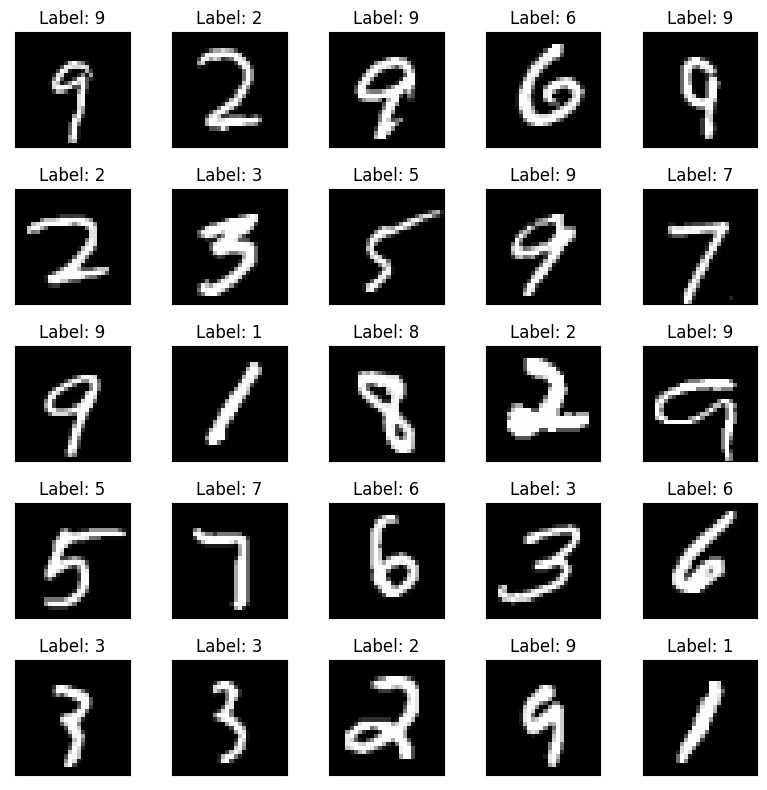

In [13]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_data)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Transform Dataloader

In [14]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [15]:
m=len(train_data)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_data, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

# 3. Initialize model

In [16]:
from engine import Engine

In [17]:
torch.manual_seed(0)
engine = Engine(encoded_space_dim=4,num_epochs=config.NUM_EPOCHS)

In [18]:
encoder, decoder = engine.get_autoencoder()

## Some Examples

In [12]:
# Take an input image (remember to add the batch dimension)
img, _ = test_data[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


# 4. Train Model

In [23]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [14]:
loss_data = engine.train_model("mse", train_loader,valid_loader, loss_fn, optim)


 EPOCH 1/30 	 train loss0.123 	 val loss 0.066

 EPOCH 6/30 	 train loss0.031 	 val loss 0.031

 EPOCH 11/30 	 train loss0.028 	 val loss 0.029

 EPOCH 16/30 	 train loss0.027 	 val loss 0.028

 EPOCH 21/30 	 train loss0.027 	 val loss 0.027

 EPOCH 26/30 	 train loss0.026 	 val loss 0.027


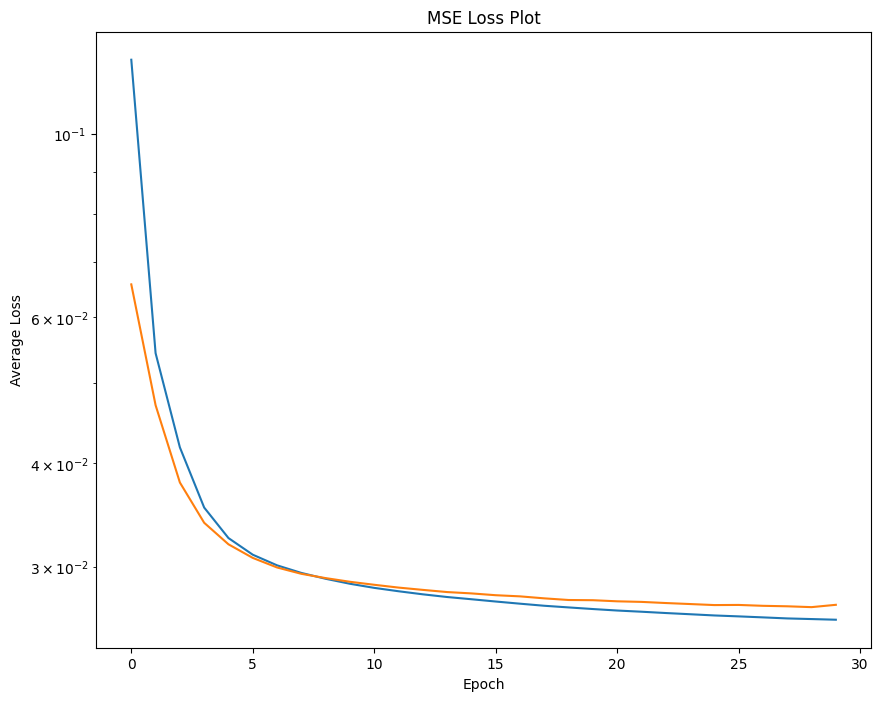

In [15]:
engine.plot_train_loss(loss_data,"MSE Loss Plot")

# 5. Latent Space Exploration

In [5]:
import embedding_util as util

In [18]:
# Generate embeddings dataframe
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder = torch.load('temp\\best_mse_encoder.pth')
embeddings_df = util.get_latent_space_embeddings(test_data, device, encoder)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 912.80it/s]


In [19]:
embeddings_df

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-1.899173,1.992174,0.376374,0.379166,7
1,0.692663,0.763920,1.866628,0.040005,2
2,0.284727,1.627902,-0.126284,0.923841,1
3,-0.356200,-0.871710,0.202812,-0.406451,0
4,-0.724351,0.468064,-1.068795,-0.587070,4
...,...,...,...,...,...
9995,-0.267300,0.593891,1.743525,1.105742,2
9996,0.442625,-0.027045,0.705509,-0.420771,3
9997,-0.727120,0.660905,-0.901352,0.284138,4
9998,0.345617,-0.528037,-0.692538,0.519677,5


In [20]:
embeddings_df.label

0       7
1       2
2       1
3       0
4       4
       ..
9995    2
9996    3
9997    4
9998    5
9999    6
Name: label, Length: 10000, dtype: int64

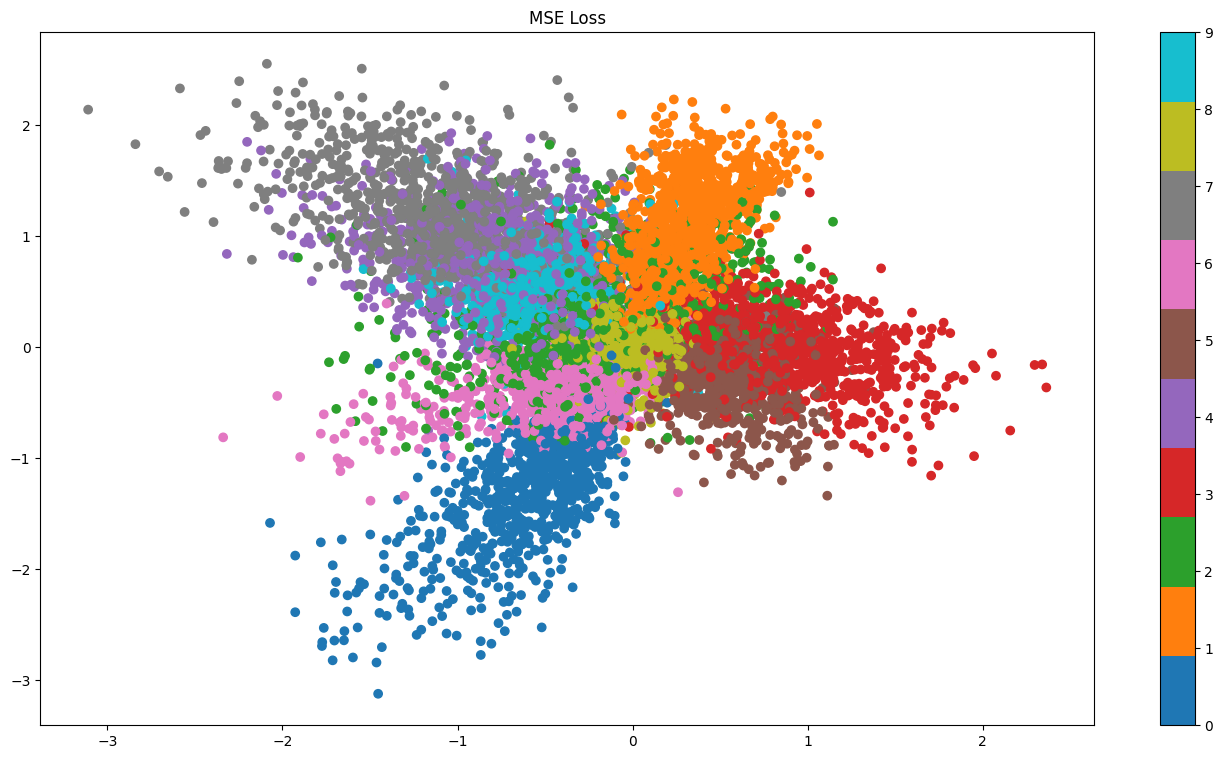

In [23]:
util.visualize_embeddings_2D(embeddings_df['Enc. Variable 0'], embeddings_df['Enc. Variable 1'], embeddings_df.label, "MSE Loss")

## Cluster Latent Space and visualize

In [6]:
from sklearn.manifold import TSNE

C:\Users\Skyfire\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Skyfire\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


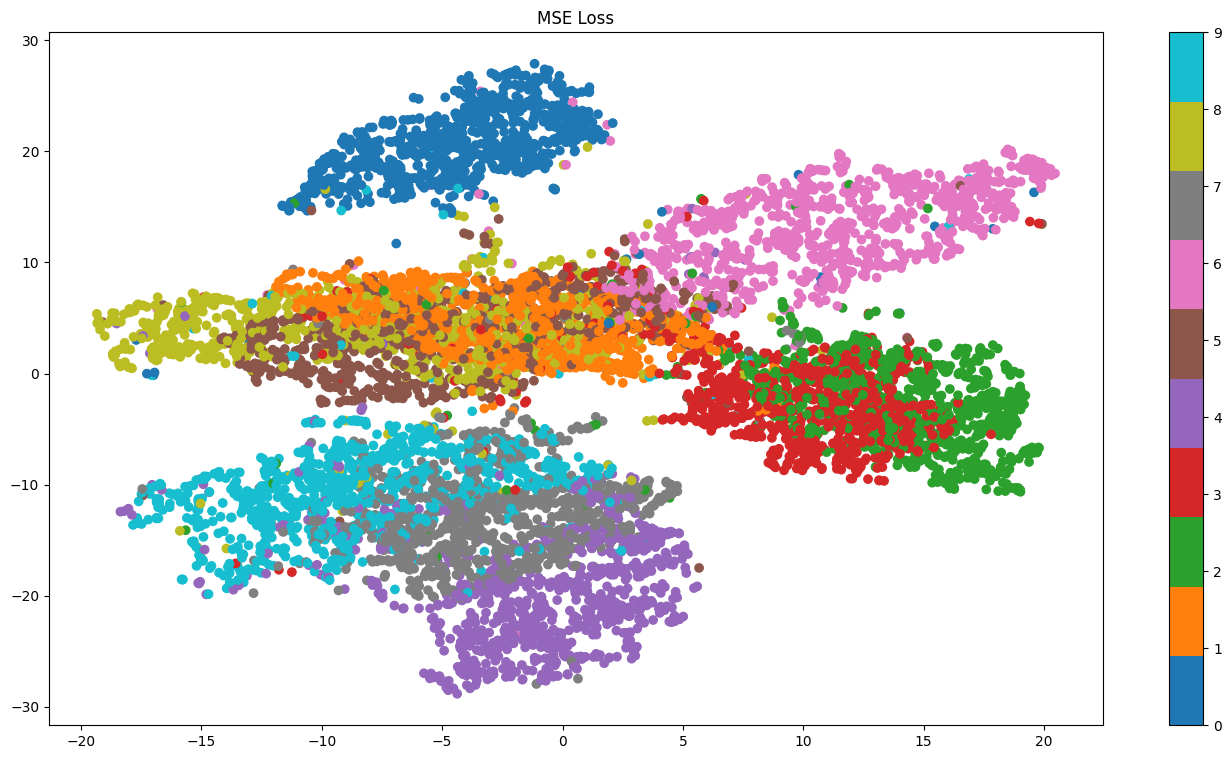

In [26]:
tsne = TSNE(n_components=3)
util.cluster_latent_space(tsne, embeddings_df, "MSE Loss")

# EXPERIMENTS

## Experiment 1: Impact of Loss Functions on Embeddings

In [7]:
from config import Loss_fns
from sklearn.decomposition import PCA


 EPOCH 1/30 	 train loss0.025 	 val loss 0.026

 EPOCH 6/30 	 train loss0.025 	 val loss 0.026

 EPOCH 11/30 	 train loss0.025 	 val loss 0.026

 EPOCH 16/30 	 train loss0.025 	 val loss 0.026

 EPOCH 21/30 	 train loss0.025 	 val loss 0.026

 EPOCH 26/30 	 train loss0.025 	 val loss 0.026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 834.20it/s]
C:\Users\Skyfire\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Skyfire\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


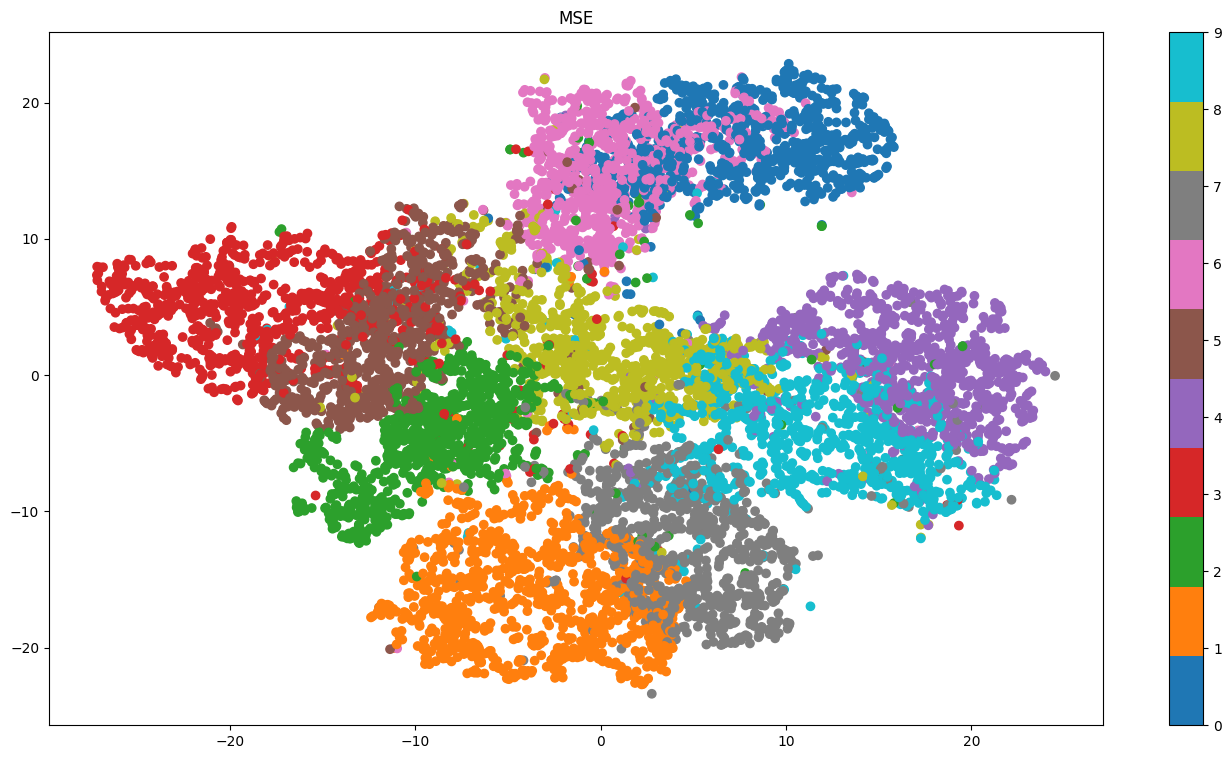


 EPOCH 1/30 	 train loss0.000 	 val loss -0.000

 EPOCH 6/30 	 train loss0.000 	 val loss -0.000

 EPOCH 11/30 	 train loss0.000 	 val loss -0.000

 EPOCH 16/30 	 train loss0.000 	 val loss -0.000

 EPOCH 21/30 	 train loss0.000 	 val loss -0.000

 EPOCH 26/30 	 train loss0.000 	 val loss -0.000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 834.46it/s]
C:\Users\Skyfire\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Skyfire\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


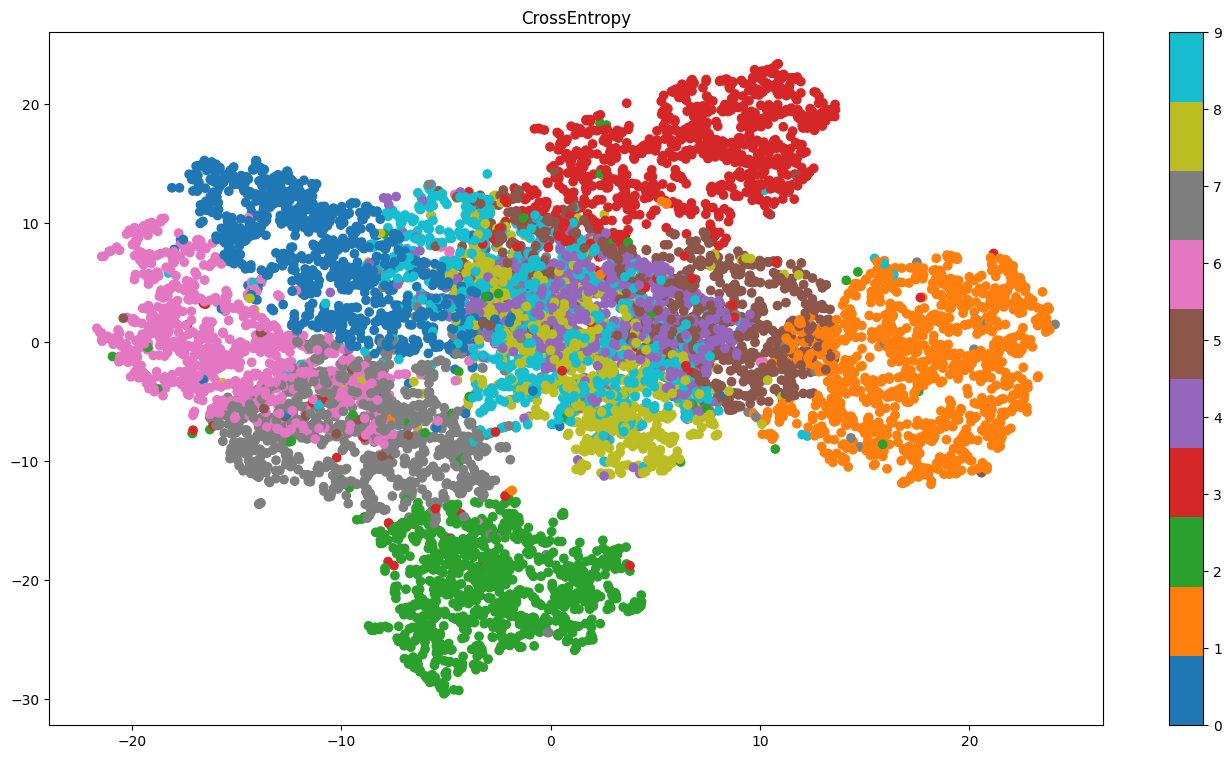

TypeError: forward() missing 1 required positional argument: 'negative'

In [29]:
for loss_fn in Loss_fns:
    # Initialize parameters
    lr= 0.001
    params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}]

    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
    loss_data = engine.train_model(loss_fn, train_loader,valid_loader, Loss_fns[loss_fn], optim)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    encoder = torch.load(f'temp\\best_{loss_fn}_encoder.pth')
    embeddings_df = util.get_latent_space_embeddings(test_data, device, encoder)
    
    tsne = TSNE(n_components=3)
    util.cluster_latent_space(tsne, embeddings_df,experiment_name=loss_fn)

In [37]:
def get_default_device():
#””Pick GPU if available, else CPU”””
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [30]:
train_data = datasets.MNIST(root=config.DATA_DIR, train=True,
                                   download=True)
test_data = datasets.MNIST(root=config.DATA_DIR, train=False,
                                  download=True)

In [31]:
from triplet_loss_dataset import TripletDataset

In [38]:
BATCH_SIZE = 64
DEVICE = get_default_device()

In [39]:
transform = transforms.Compose([transforms.ToTensor()])
triplet_dataset = TripletDataset(train_data,transform=transform)

In [40]:
train_dl = DataLoader(triplet_dataset,batch_size=config.BATCH_SIZE,shuffle=True, num_workers=4, pin_memory=True)

In [41]:
criterion = torch.nn.TripletMarginLoss()
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [44]:
from model import Encoder, Decoder

In [52]:
def autoencoder_model(img):
    encoder = Encoder(encoded_space_dim=4,
                               fc2_input_dim=128)
    decoder = Decoder(encoded_space_dim=4)
    encoder = encoder.to(DEVICE)
    decoder = decoder.to(DEVICE)
    encoded = encoder(img)
    output = decoder(encoded)
    return output

In [ ]:
for epoch in tqdm(range(config.EPOCHS), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_dl, desc="Training", leave=False)):
        # print(step)
        anchor_img = anchor_img.to(DEVICE)
        # print(anchor_img.shape)
        positive_img = positive_img.to(DEVICE)
        negative_img = negative_img.to(DEVICE)
        # break
        optim.zero_grad()
        anchor_out = autoencoder_model(anchor_img)
        positive_out = autoencoder_model(positive_img)
        negative_out = autoencoder_model(negative_img)
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optim.step()
        running_loss.append(loss.cpu().detach().numpy())
        print("Epoch: {}/{} — Loss: {:.4f}".format(epoch+1, config.EPOCHS, np.mean(running_loss)))

Training:   0%|▏                                                                                                                                                            | 4/3000 [01:14<11:40:24, 14.03s/it]

Epoch: 1/10 — Loss: 1.4338
Epoch: 1/10 — Loss: 1.2242
Epoch: 1/10 — Loss: 1.0995
Epoch: 1/10 — Loss: 1.0820



Training:   0%|▍                                                                                                                                                            | 8/3000 [02:14<10:12:16, 12.28s/it]

Epoch: 1/10 — Loss: 1.0451
Epoch: 1/10 — Loss: 1.0550
Epoch: 1/10 — Loss: 1.0330
Epoch: 1/10 — Loss: 1.0208



Training:   0%|▌                                                                                                                                                           | 12/3000 [03:19<10:12:54, 12.31s/it]

Epoch: 1/10 — Loss: 1.0344
Epoch: 1/10 — Loss: 1.0251
Epoch: 1/10 — Loss: 0.9963
Epoch: 1/10 — Loss: 0.9941



Training:   1%|▊                                                                                                                                                           | 16/3000 [04:23<10:07:42, 12.22s/it]

Epoch: 1/10 — Loss: 0.9943
Epoch: 1/10 — Loss: 1.0144
Epoch: 1/10 — Loss: 1.0065
Epoch: 1/10 — Loss: 1.0118



Training:   1%|█                                                                                                                                                           | 20/3000 [05:28<10:06:31, 12.21s/it]

Epoch: 1/10 — Loss: 0.9942
Epoch: 1/10 — Loss: 1.0018
Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9921



Training:   1%|█▏                                                                                                                                                          | 24/3000 [06:32<10:03:37, 12.17s/it]

Epoch: 1/10 — Loss: 0.9748
Epoch: 1/10 — Loss: 0.9777
Epoch: 1/10 — Loss: 0.9813
Epoch: 1/10 — Loss: 0.9782



Training:   1%|█▍                                                                                                                                                          | 28/3000 [07:36<10:03:18, 12.18s/it]

Epoch: 1/10 — Loss: 0.9767
Epoch: 1/10 — Loss: 0.9804
Epoch: 1/10 — Loss: 0.9896
Epoch: 1/10 — Loss: 0.9960



Training:   1%|█▋                                                                                                                                                          | 32/3000 [08:40<10:02:32, 12.18s/it]

Epoch: 1/10 — Loss: 1.0003
Epoch: 1/10 — Loss: 1.0004
Epoch: 1/10 — Loss: 0.9927
Epoch: 1/10 — Loss: 0.9878



Training:   1%|█▊                                                                                                                                                          | 36/3000 [09:45<10:02:46, 12.20s/it]

Epoch: 1/10 — Loss: 0.9883
Epoch: 1/10 — Loss: 0.9927
Epoch: 1/10 — Loss: 0.9927
Epoch: 1/10 — Loss: 1.0018



Training:   1%|██                                                                                                                                                          | 40/3000 [10:49<10:00:45, 12.18s/it]

Epoch: 1/10 — Loss: 1.0028
Epoch: 1/10 — Loss: 1.0076
Epoch: 1/10 — Loss: 1.0055
Epoch: 1/10 — Loss: 1.0065



Training:   1%|██▎                                                                                                                                                         | 44/3000 [11:54<10:02:38, 12.23s/it]

Epoch: 1/10 — Loss: 1.0048
Epoch: 1/10 — Loss: 1.0101
Epoch: 1/10 — Loss: 1.0136
Epoch: 1/10 — Loss: 1.0156



Training:   2%|██▌                                                                                                                                                          | 48/3000 [12:53<9:35:00, 11.69s/it]

Epoch: 1/10 — Loss: 1.0139
Epoch: 1/10 — Loss: 1.0103
Epoch: 1/10 — Loss: 1.0171
Epoch: 1/10 — Loss: 1.0153



Training:   2%|██▋                                                                                                                                                          | 52/3000 [13:50<9:14:18, 11.28s/it]

Epoch: 1/10 — Loss: 1.0149
Epoch: 1/10 — Loss: 1.0151
Epoch: 1/10 — Loss: 1.0145
Epoch: 1/10 — Loss: 1.0222



Training:   2%|██▉                                                                                                                                                          | 56/3000 [14:51<9:19:30, 11.40s/it]

Epoch: 1/10 — Loss: 1.0206
Epoch: 1/10 — Loss: 1.0241
Epoch: 1/10 — Loss: 1.0250
Epoch: 1/10 — Loss: 1.0251



Training:   2%|███▏                                                                                                                                                         | 60/3000 [15:48<9:04:02, 11.10s/it]

Epoch: 1/10 — Loss: 1.0237
Epoch: 1/10 — Loss: 1.0210
Epoch: 1/10 — Loss: 1.0224
Epoch: 1/10 — Loss: 1.0245



Training:   2%|███▎                                                                                                                                                         | 64/3000 [16:46<8:57:44, 10.99s/it]

Epoch: 1/10 — Loss: 1.0295
Epoch: 1/10 — Loss: 1.0343
Epoch: 1/10 — Loss: 1.0340
Epoch: 1/10 — Loss: 1.0336



Training:   2%|███▌                                                                                                                                                         | 68/3000 [17:44<8:56:23, 10.98s/it]

Epoch: 1/10 — Loss: 1.0319
Epoch: 1/10 — Loss: 1.0313
Epoch: 1/10 — Loss: 1.0321
Epoch: 1/10 — Loss: 1.0303



Training:   2%|███▊                                                                                                                                                         | 72/3000 [18:42<8:56:49, 11.00s/it]

Epoch: 1/10 — Loss: 1.0303
Epoch: 1/10 — Loss: 1.0313
Epoch: 1/10 — Loss: 1.0316
Epoch: 1/10 — Loss: 1.0280



Training:   3%|███▉                                                                                                                                                         | 76/3000 [19:39<8:51:08, 10.90s/it]

Epoch: 1/10 — Loss: 1.0220
Epoch: 1/10 — Loss: 1.0232
Epoch: 1/10 — Loss: 1.0218
Epoch: 1/10 — Loss: 1.0205



Training:   3%|████▏                                                                                                                                                        | 80/3000 [20:36<8:47:37, 10.84s/it]

Epoch: 1/10 — Loss: 1.0218
Epoch: 1/10 — Loss: 1.0200
Epoch: 1/10 — Loss: 1.0195
Epoch: 1/10 — Loss: 1.0196



Training:   3%|████▍                                                                                                                                                        | 84/3000 [21:33<8:46:42, 10.84s/it]

Epoch: 1/10 — Loss: 1.0175
Epoch: 1/10 — Loss: 1.0187
Epoch: 1/10 — Loss: 1.0195
Epoch: 1/10 — Loss: 1.0207



Training:   3%|████▌                                                                                                                                                        | 88/3000 [22:30<8:43:30, 10.79s/it]

Epoch: 1/10 — Loss: 1.0214
Epoch: 1/10 — Loss: 1.0214
Epoch: 1/10 — Loss: 1.0173
Epoch: 1/10 — Loss: 1.0179



Training:   3%|████▊                                                                                                                                                        | 92/3000 [23:26<8:40:14, 10.73s/it]

Epoch: 1/10 — Loss: 1.0222
Epoch: 1/10 — Loss: 1.0242
Epoch: 1/10 — Loss: 1.0249
Epoch: 1/10 — Loss: 1.0259



Training:   3%|█████                                                                                                                                                        | 96/3000 [24:23<8:40:26, 10.75s/it]

Epoch: 1/10 — Loss: 1.0257
Epoch: 1/10 — Loss: 1.0245
Epoch: 1/10 — Loss: 1.0271
Epoch: 1/10 — Loss: 1.0276



Training:   3%|█████▏                                                                                                                                                      | 100/3000 [25:19<8:36:36, 10.69s/it]

Epoch: 1/10 — Loss: 1.0266
Epoch: 1/10 — Loss: 1.0268
Epoch: 1/10 — Loss: 1.0272
Epoch: 1/10 — Loss: 1.0282



Training:   3%|█████▍                                                                                                                                                      | 104/3000 [26:16<8:37:07, 10.71s/it]

Epoch: 1/10 — Loss: 1.0267
Epoch: 1/10 — Loss: 1.0267
Epoch: 1/10 — Loss: 1.0261
Epoch: 1/10 — Loss: 1.0277



Training:   4%|█████▌                                                                                                                                                      | 108/3000 [27:13<8:37:03, 10.73s/it]

Epoch: 1/10 — Loss: 1.0264
Epoch: 1/10 — Loss: 1.0256
Epoch: 1/10 — Loss: 1.0260
Epoch: 1/10 — Loss: 1.0274



Training:   4%|█████▊                                                                                                                                                      | 112/3000 [28:09<8:36:32, 10.73s/it]

Epoch: 1/10 — Loss: 1.0260
Epoch: 1/10 — Loss: 1.0247
Epoch: 1/10 — Loss: 1.0254
Epoch: 1/10 — Loss: 1.0251



Training:   4%|██████                                                                                                                                                      | 116/3000 [29:07<8:39:36, 10.81s/it]

Epoch: 1/10 — Loss: 1.0238
Epoch: 1/10 — Loss: 1.0242
Epoch: 1/10 — Loss: 1.0222
Epoch: 1/10 — Loss: 1.0215



Training:   4%|██████▏                                                                                                                                                     | 120/3000 [30:04<8:37:36, 10.78s/it]

Epoch: 1/10 — Loss: 1.0194
Epoch: 1/10 — Loss: 1.0177
Epoch: 1/10 — Loss: 1.0183
Epoch: 1/10 — Loss: 1.0169



Training:   4%|██████▍                                                                                                                                                     | 124/3000 [31:00<8:34:59, 10.74s/it]

Epoch: 1/10 — Loss: 1.0151
Epoch: 1/10 — Loss: 1.0166
Epoch: 1/10 — Loss: 1.0171
Epoch: 1/10 — Loss: 1.0165



Training:   4%|██████▋                                                                                                                                                     | 128/3000 [31:56<8:31:12, 10.68s/it]

Epoch: 1/10 — Loss: 1.0176
Epoch: 1/10 — Loss: 1.0173
Epoch: 1/10 — Loss: 1.0154
Epoch: 1/10 — Loss: 1.0148



Training:   4%|██████▊                                                                                                                                                     | 132/3000 [32:55<8:39:07, 10.86s/it]

Epoch: 1/10 — Loss: 1.0118
Epoch: 1/10 — Loss: 1.0114
Epoch: 1/10 — Loss: 1.0130
Epoch: 1/10 — Loss: 1.0121



Training:   5%|███████                                                                                                                                                     | 136/3000 [33:51<8:35:23, 10.80s/it]

Epoch: 1/10 — Loss: 1.0118
Epoch: 1/10 — Loss: 1.0109
Epoch: 1/10 — Loss: 1.0097
Epoch: 1/10 — Loss: 1.0100



Training:   5%|███████▎                                                                                                                                                    | 140/3000 [34:48<8:34:07, 10.79s/it]

Epoch: 1/10 — Loss: 1.0094
Epoch: 1/10 — Loss: 1.0086
Epoch: 1/10 — Loss: 1.0081
Epoch: 1/10 — Loss: 1.0086



Training:   5%|███████▍                                                                                                                                                    | 144/3000 [35:45<8:31:30, 10.75s/it]

Epoch: 1/10 — Loss: 1.0065
Epoch: 1/10 — Loss: 1.0063
Epoch: 1/10 — Loss: 1.0057
Epoch: 1/10 — Loss: 1.0080



Training:   5%|███████▋                                                                                                                                                    | 148/3000 [36:42<8:34:17, 10.82s/it]

Epoch: 1/10 — Loss: 1.0049
Epoch: 1/10 — Loss: 1.0051
Epoch: 1/10 — Loss: 1.0079
Epoch: 1/10 — Loss: 1.0074



Training:   5%|███████▉                                                                                                                                                    | 152/3000 [37:39<8:30:59, 10.77s/it]

Epoch: 1/10 — Loss: 1.0070
Epoch: 1/10 — Loss: 1.0073
Epoch: 1/10 — Loss: 1.0057
Epoch: 1/10 — Loss: 1.0048



Training:   5%|████████                                                                                                                                                    | 156/3000 [38:35<8:27:10, 10.70s/it]

Epoch: 1/10 — Loss: 1.0047
Epoch: 1/10 — Loss: 1.0055
Epoch: 1/10 — Loss: 1.0051
Epoch: 1/10 — Loss: 1.0062



Training:   5%|████████▎                                                                                                                                                   | 160/3000 [39:32<8:27:44, 10.73s/it]

Epoch: 1/10 — Loss: 1.0073
Epoch: 1/10 — Loss: 1.0072
Epoch: 1/10 — Loss: 1.0075
Epoch: 1/10 — Loss: 1.0068



Training:   5%|████████▌                                                                                                                                                   | 164/3000 [40:37<9:08:05, 11.60s/it]

Epoch: 1/10 — Loss: 1.0055
Epoch: 1/10 — Loss: 1.0058
Epoch: 1/10 — Loss: 1.0056
Epoch: 1/10 — Loss: 1.0055



Training:   6%|████████▋                                                                                                                                                   | 168/3000 [41:43<9:29:05, 12.06s/it]

Epoch: 1/10 — Loss: 1.0048
Epoch: 1/10 — Loss: 1.0044
Epoch: 1/10 — Loss: 1.0041
Epoch: 1/10 — Loss: 1.0033



Training:   6%|████████▉                                                                                                                                                   | 172/3000 [42:48<9:31:37, 12.13s/it]

Epoch: 1/10 — Loss: 1.0025
Epoch: 1/10 — Loss: 1.0023
Epoch: 1/10 — Loss: 1.0036
Epoch: 1/10 — Loss: 1.0033



Training:   6%|█████████▏                                                                                                                                                  | 176/3000 [43:53<9:34:05, 12.20s/it]

Epoch: 1/10 — Loss: 1.0036
Epoch: 1/10 — Loss: 1.0030
Epoch: 1/10 — Loss: 1.0018
Epoch: 1/10 — Loss: 1.0020



Training:   6%|█████████▎                                                                                                                                                  | 180/3000 [44:57<9:31:23, 12.16s/it]

Epoch: 1/10 — Loss: 1.0019
Epoch: 1/10 — Loss: 1.0016
Epoch: 1/10 — Loss: 1.0028
Epoch: 1/10 — Loss: 1.0026



Training:   6%|█████████▌                                                                                                                                                  | 184/3000 [46:01<9:31:42, 12.18s/it]

Epoch: 1/10 — Loss: 1.0026
Epoch: 1/10 — Loss: 1.0007
Epoch: 1/10 — Loss: 1.0008
Epoch: 1/10 — Loss: 1.0003



Training:   6%|█████████▊                                                                                                                                                  | 188/3000 [47:06<9:32:26, 12.21s/it]

Epoch: 1/10 — Loss: 1.0010
Epoch: 1/10 — Loss: 0.9996
Epoch: 1/10 — Loss: 0.9989
Epoch: 1/10 — Loss: 0.9996



Training:   6%|█████████▉                                                                                                                                                  | 192/3000 [48:10<9:31:52, 12.22s/it]

Epoch: 1/10 — Loss: 0.9992
Epoch: 1/10 — Loss: 0.9998
Epoch: 1/10 — Loss: 0.9998
Epoch: 1/10 — Loss: 0.9993



Training:   7%|██████████▏                                                                                                                                                 | 196/3000 [49:15<9:33:38, 12.27s/it]

Epoch: 1/10 — Loss: 0.9983
Epoch: 1/10 — Loss: 0.9996
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 1.0011



Training:   7%|██████████▍                                                                                                                                                 | 200/3000 [50:19<9:28:00, 12.17s/it]

Epoch: 1/10 — Loss: 1.0015
Epoch: 1/10 — Loss: 1.0015
Epoch: 1/10 — Loss: 1.0008
Epoch: 1/10 — Loss: 1.0008



Training:   7%|██████████▌                                                                                                                                                 | 204/3000 [51:23<9:23:17, 12.09s/it]

Epoch: 1/10 — Loss: 1.0009
Epoch: 1/10 — Loss: 1.0019
Epoch: 1/10 — Loss: 1.0020
Epoch: 1/10 — Loss: 1.0017



Training:   7%|██████████▊                                                                                                                                                 | 208/3000 [52:26<9:21:49, 12.07s/it]

Epoch: 1/10 — Loss: 1.0013
Epoch: 1/10 — Loss: 1.0020
Epoch: 1/10 — Loss: 1.0036
Epoch: 1/10 — Loss: 1.0031



Training:   7%|███████████                                                                                                                                                 | 212/3000 [53:30<9:21:09, 12.08s/it]

Epoch: 1/10 — Loss: 1.0031
Epoch: 1/10 — Loss: 1.0027
Epoch: 1/10 — Loss: 1.0032
Epoch: 1/10 — Loss: 1.0019



Training:   7%|███████████                                                                                                                                                | 215/3000 [54:38<11:11:01, 14.46s/it]

Epoch: 1/10 — Loss: 1.0028
Epoch: 1/10 — Loss: 1.0033
Epoch: 1/10 — Loss: 1.0048
Epoch: 1/10 — Loss: 1.0049



Training:   7%|███████████▍                                                                                                                                                | 220/3000 [55:41<9:08:27, 11.84s/it]

Epoch: 1/10 — Loss: 1.0051
Epoch: 1/10 — Loss: 1.0051
Epoch: 1/10 — Loss: 1.0054
Epoch: 1/10 — Loss: 1.0049



Training:   7%|███████████▋                                                                                                                                                | 224/3000 [56:41<8:57:17, 11.61s/it]

Epoch: 1/10 — Loss: 1.0051
Epoch: 1/10 — Loss: 1.0049
Epoch: 1/10 — Loss: 1.0056
Epoch: 1/10 — Loss: 1.0082



Training:   8%|███████████▊                                                                                                                                                | 228/3000 [57:43<8:59:11, 11.67s/it]

Epoch: 1/10 — Loss: 1.0075
Epoch: 1/10 — Loss: 1.0083
Epoch: 1/10 — Loss: 1.0071
Epoch: 1/10 — Loss: 1.0072



Training:   8%|████████████                                                                                                                                                | 232/3000 [58:44<8:57:01, 11.64s/it]

Epoch: 1/10 — Loss: 1.0071
Epoch: 1/10 — Loss: 1.0072
Epoch: 1/10 — Loss: 1.0076
Epoch: 1/10 — Loss: 1.0075



Training:   8%|████████████▎                                                                                                                                               | 236/3000 [59:46<8:57:46, 11.67s/it]

Epoch: 1/10 — Loss: 1.0074
Epoch: 1/10 — Loss: 1.0065
Epoch: 1/10 — Loss: 1.0060
Epoch: 1/10 — Loss: 1.0057



Training:   8%|████████████▎                                                                                                                                             | 240/3000 [1:00:47<8:53:04, 11.59s/it]

Epoch: 1/10 — Loss: 1.0039
Epoch: 1/10 — Loss: 1.0042
Epoch: 1/10 — Loss: 1.0045
Epoch: 1/10 — Loss: 1.0035



Training:   8%|████████████▌                                                                                                                                             | 244/3000 [1:01:47<8:48:15, 11.50s/it]

Epoch: 1/10 — Loss: 1.0043
Epoch: 1/10 — Loss: 1.0043
Epoch: 1/10 — Loss: 1.0034
Epoch: 1/10 — Loss: 1.0036



Training:   8%|████████████▋                                                                                                                                             | 248/3000 [1:02:49<8:52:39, 11.61s/it]

Epoch: 1/10 — Loss: 1.0032
Epoch: 1/10 — Loss: 1.0032
Epoch: 1/10 — Loss: 1.0029
Epoch: 1/10 — Loss: 1.0045



Training:   8%|████████████▉                                                                                                                                             | 252/3000 [1:03:49<8:47:28, 11.52s/it]

Epoch: 1/10 — Loss: 1.0034
Epoch: 1/10 — Loss: 1.0032
Epoch: 1/10 — Loss: 1.0037
Epoch: 1/10 — Loss: 1.0021



Training:   9%|█████████████▏                                                                                                                                            | 256/3000 [1:04:53<9:00:18, 11.81s/it]

Epoch: 1/10 — Loss: 1.0019
Epoch: 1/10 — Loss: 1.0011
Epoch: 1/10 — Loss: 1.0006
Epoch: 1/10 — Loss: 0.9991



Training:   9%|█████████████▏                                                                                                                                           | 259/3000 [1:05:54<10:17:02, 13.51s/it]

Epoch: 1/10 — Loss: 0.9985
Epoch: 1/10 — Loss: 0.9982
Epoch: 1/10 — Loss: 0.9983
Epoch: 1/10 — Loss: 0.9989



Training:   9%|█████████████▌                                                                                                                                            | 264/3000 [1:06:54<8:29:07, 11.17s/it]

Epoch: 1/10 — Loss: 1.0001
Epoch: 1/10 — Loss: 1.0000
Epoch: 1/10 — Loss: 1.0009
Epoch: 1/10 — Loss: 1.0014



Training:   9%|█████████████▊                                                                                                                                            | 268/3000 [1:07:53<8:31:44, 11.24s/it]

Epoch: 1/10 — Loss: 1.0017
Epoch: 1/10 — Loss: 1.0017
Epoch: 1/10 — Loss: 1.0027
Epoch: 1/10 — Loss: 1.0032



Training:   9%|█████████████▉                                                                                                                                            | 272/3000 [1:08:53<8:32:22, 11.27s/it]

Epoch: 1/10 — Loss: 1.0025
Epoch: 1/10 — Loss: 1.0025
Epoch: 1/10 — Loss: 1.0035
Epoch: 1/10 — Loss: 1.0018



Training:   9%|██████████████▏                                                                                                                                           | 276/3000 [1:09:52<8:30:28, 11.24s/it]

Epoch: 1/10 — Loss: 1.0020
Epoch: 1/10 — Loss: 1.0025
Epoch: 1/10 — Loss: 1.0022
Epoch: 1/10 — Loss: 1.0019



Training:   9%|██████████████▎                                                                                                                                           | 280/3000 [1:10:52<8:29:34, 11.24s/it]

Epoch: 1/10 — Loss: 1.0023
Epoch: 1/10 — Loss: 1.0020
Epoch: 1/10 — Loss: 1.0025
Epoch: 1/10 — Loss: 1.0036



Training:   9%|██████████████▌                                                                                                                                           | 284/3000 [1:11:51<8:28:26, 11.23s/it]

Epoch: 1/10 — Loss: 1.0038
Epoch: 1/10 — Loss: 1.0035
Epoch: 1/10 — Loss: 1.0029
Epoch: 1/10 — Loss: 1.0027



Training:  10%|██████████████▋                                                                                                                                           | 287/3000 [1:12:51<9:52:01, 13.09s/it]

Epoch: 1/10 — Loss: 1.0039
Epoch: 1/10 — Loss: 1.0042
Epoch: 1/10 — Loss: 1.0038
Epoch: 1/10 — Loss: 1.0028



Training:  10%|██████████████▉                                                                                                                                           | 292/3000 [1:13:51<8:15:12, 10.97s/it]

Epoch: 1/10 — Loss: 1.0022
Epoch: 1/10 — Loss: 1.0026
Epoch: 1/10 — Loss: 1.0028
Epoch: 1/10 — Loss: 1.0037



Training:  10%|███████████████▏                                                                                                                                          | 296/3000 [1:14:51<8:23:22, 11.17s/it]

Epoch: 1/10 — Loss: 1.0036
Epoch: 1/10 — Loss: 1.0037
Epoch: 1/10 — Loss: 1.0025
Epoch: 1/10 — Loss: 1.0022



Training:  10%|███████████████▍                                                                                                                                          | 300/3000 [1:15:45<8:01:46, 10.71s/it]

Epoch: 1/10 — Loss: 1.0024
Epoch: 1/10 — Loss: 1.0026
Epoch: 1/10 — Loss: 1.0023
Epoch: 1/10 — Loss: 1.0023



Training:  10%|███████████████▌                                                                                                                                          | 304/3000 [1:16:39<7:51:57, 10.50s/it]

Epoch: 1/10 — Loss: 1.0025
Epoch: 1/10 — Loss: 1.0029
Epoch: 1/10 — Loss: 1.0038
Epoch: 1/10 — Loss: 1.0036



Training:  10%|███████████████▊                                                                                                                                          | 308/3000 [1:17:34<7:47:17, 10.42s/it]

Epoch: 1/10 — Loss: 1.0042
Epoch: 1/10 — Loss: 1.0045
Epoch: 1/10 — Loss: 1.0031
Epoch: 1/10 — Loss: 1.0032



Training:  10%|████████████████                                                                                                                                          | 312/3000 [1:18:28<7:44:15, 10.36s/it]

Epoch: 1/10 — Loss: 1.0039
Epoch: 1/10 — Loss: 1.0040
Epoch: 1/10 — Loss: 1.0037
Epoch: 1/10 — Loss: 1.0028



Training:  11%|████████████████▏                                                                                                                                         | 316/3000 [1:19:23<7:42:21, 10.34s/it]

Epoch: 1/10 — Loss: 1.0031
Epoch: 1/10 — Loss: 1.0035
Epoch: 1/10 — Loss: 1.0029
Epoch: 1/10 — Loss: 1.0026



Training:  11%|████████████████▍                                                                                                                                         | 320/3000 [1:20:17<7:41:19, 10.33s/it]

Epoch: 1/10 — Loss: 1.0024
Epoch: 1/10 — Loss: 1.0021
Epoch: 1/10 — Loss: 1.0029
Epoch: 1/10 — Loss: 1.0034



Training:  11%|████████████████▋                                                                                                                                         | 324/3000 [1:21:11<7:39:45, 10.31s/it]

Epoch: 1/10 — Loss: 1.0030
Epoch: 1/10 — Loss: 1.0019
Epoch: 1/10 — Loss: 1.0018
Epoch: 1/10 — Loss: 1.0011



Training:  11%|████████████████▊                                                                                                                                         | 328/3000 [1:22:06<7:39:43, 10.32s/it]

Epoch: 1/10 — Loss: 1.0010
Epoch: 1/10 — Loss: 1.0006
Epoch: 1/10 — Loss: 1.0013
Epoch: 1/10 — Loss: 1.0009



Training:  11%|█████████████████                                                                                                                                         | 332/3000 [1:23:00<7:38:14, 10.31s/it]

Epoch: 1/10 — Loss: 1.0019
Epoch: 1/10 — Loss: 1.0015
Epoch: 1/10 — Loss: 0.9998
Epoch: 1/10 — Loss: 1.0004



Training:  11%|█████████████████▏                                                                                                                                        | 336/3000 [1:23:55<7:37:11, 10.30s/it]

Epoch: 1/10 — Loss: 1.0001
Epoch: 1/10 — Loss: 1.0004
Epoch: 1/10 — Loss: 0.9997
Epoch: 1/10 — Loss: 1.0004



Training:  11%|█████████████████▍                                                                                                                                        | 340/3000 [1:24:49<7:36:05, 10.29s/it]

Epoch: 1/10 — Loss: 0.9999
Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9995
Epoch: 1/10 — Loss: 0.9989



Training:  11%|█████████████████▋                                                                                                                                        | 344/3000 [1:25:44<7:36:57, 10.32s/it]

Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9988
Epoch: 1/10 — Loss: 0.9986
Epoch: 1/10 — Loss: 0.9992



Training:  12%|█████████████████▊                                                                                                                                        | 348/3000 [1:26:38<7:36:47, 10.33s/it]

Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9989
Epoch: 1/10 — Loss: 0.9992
Epoch: 1/10 — Loss: 0.9986



Training:  12%|██████████████████                                                                                                                                        | 352/3000 [1:27:33<7:36:26, 10.34s/it]

Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9982
Epoch: 1/10 — Loss: 0.9970
Epoch: 1/10 — Loss: 0.9977



Training:  12%|██████████████████▎                                                                                                                                       | 356/3000 [1:28:27<7:35:06, 10.33s/it]

Epoch: 1/10 — Loss: 0.9985
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9993
Epoch: 1/10 — Loss: 0.9998



Training:  12%|██████████████████▍                                                                                                                                       | 360/3000 [1:29:22<7:34:50, 10.34s/it]

Epoch: 1/10 — Loss: 0.9986
Epoch: 1/10 — Loss: 0.9988
Epoch: 1/10 — Loss: 0.9987
Epoch: 1/10 — Loss: 0.9983



Training:  12%|██████████████████▋                                                                                                                                       | 364/3000 [1:30:16<7:32:55, 10.31s/it]

Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9980
Epoch: 1/10 — Loss: 0.9985
Epoch: 1/10 — Loss: 0.9982



Training:  12%|██████████████████▉                                                                                                                                       | 368/3000 [1:31:11<7:32:46, 10.32s/it]

Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9993
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9999



Training:  12%|███████████████████                                                                                                                                       | 372/3000 [1:32:05<7:31:30, 10.31s/it]

Epoch: 1/10 — Loss: 1.0001
Epoch: 1/10 — Loss: 1.0002
Epoch: 1/10 — Loss: 1.0007
Epoch: 1/10 — Loss: 1.0009



Training:  13%|███████████████████▎                                                                                                                                      | 376/3000 [1:33:00<7:30:39, 10.30s/it]

Epoch: 1/10 — Loss: 1.0011
Epoch: 1/10 — Loss: 1.0008
Epoch: 1/10 — Loss: 1.0001
Epoch: 1/10 — Loss: 0.9998



Training:  13%|███████████████████▍                                                                                                                                      | 379/3000 [1:33:54<8:42:19, 11.96s/it]

Epoch: 1/10 — Loss: 1.0003
Epoch: 1/10 — Loss: 1.0005
Epoch: 1/10 — Loss: 0.9999
Epoch: 1/10 — Loss: 1.0002



Training:  13%|███████████████████▋                                                                                                                                      | 384/3000 [1:34:49<7:17:24, 10.03s/it]

Epoch: 1/10 — Loss: 0.9997
Epoch: 1/10 — Loss: 1.0001
Epoch: 1/10 — Loss: 1.0000
Epoch: 1/10 — Loss: 0.9998



Training:  13%|███████████████████▉                                                                                                                                      | 388/3000 [1:35:43<7:22:50, 10.17s/it]

Epoch: 1/10 — Loss: 0.9998
Epoch: 1/10 — Loss: 1.0001
Epoch: 1/10 — Loss: 0.9999
Epoch: 1/10 — Loss: 0.9994



Training:  13%|████████████████████                                                                                                                                      | 392/3000 [1:36:38<7:25:13, 10.24s/it]

Epoch: 1/10 — Loss: 0.9993
Epoch: 1/10 — Loss: 0.9987
Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9982



Training:  13%|████████████████████▎                                                                                                                                     | 396/3000 [1:37:32<7:25:10, 10.26s/it]

Epoch: 1/10 — Loss: 0.9971
Epoch: 1/10 — Loss: 0.9971
Epoch: 1/10 — Loss: 0.9967
Epoch: 1/10 — Loss: 0.9963



Training:  13%|████████████████████▌                                                                                                                                     | 400/3000 [1:38:26<7:25:41, 10.29s/it]

Epoch: 1/10 — Loss: 0.9963
Epoch: 1/10 — Loss: 0.9960
Epoch: 1/10 — Loss: 0.9966
Epoch: 1/10 — Loss: 0.9963



Training:  13%|████████████████████▋                                                                                                                                     | 404/3000 [1:39:21<7:27:18, 10.34s/it]

Epoch: 1/10 — Loss: 0.9972
Epoch: 1/10 — Loss: 0.9981
Epoch: 1/10 — Loss: 0.9980
Epoch: 1/10 — Loss: 0.9980



Training:  14%|████████████████████▉                                                                                                                                     | 408/3000 [1:40:16<7:26:09, 10.33s/it]

Epoch: 1/10 — Loss: 0.9982
Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9978



Training:  14%|█████████████████████▏                                                                                                                                    | 412/3000 [1:41:11<7:26:49, 10.36s/it]

Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9982
Epoch: 1/10 — Loss: 0.9987
Epoch: 1/10 — Loss: 0.9989



Training:  14%|█████████████████████▎                                                                                                                                    | 416/3000 [1:42:05<7:25:18, 10.34s/it]

Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9994
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9992



Training:  14%|█████████████████████▎                                                                                                                                   | 417/3000 [1:43:01<12:47:26, 17.83s/it]

Epoch: 1/10 — Loss: 0.9992
Epoch: 1/10 — Loss: 0.9996
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9993



Training:  14%|█████████████████████▊                                                                                                                                    | 424/3000 [1:43:55<7:25:49, 10.38s/it]

Epoch: 1/10 — Loss: 1.0000
Epoch: 1/10 — Loss: 0.9999
Epoch: 1/10 — Loss: 1.0006
Epoch: 1/10 — Loss: 1.0004



Training:  14%|█████████████████████▉                                                                                                                                    | 428/3000 [1:44:50<7:24:11, 10.36s/it]

Epoch: 1/10 — Loss: 1.0013
Epoch: 1/10 — Loss: 1.0005
Epoch: 1/10 — Loss: 1.0006
Epoch: 1/10 — Loss: 1.0003



Training:  14%|██████████████████████▏                                                                                                                                   | 432/3000 [1:45:44<7:22:25, 10.34s/it]

Epoch: 1/10 — Loss: 0.9998
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9994
Epoch: 1/10 — Loss: 0.9994



Training:  15%|██████████████████████▍                                                                                                                                   | 436/3000 [1:46:39<7:22:00, 10.34s/it]

Epoch: 1/10 — Loss: 0.9993
Epoch: 1/10 — Loss: 0.9992
Epoch: 1/10 — Loss: 0.9987
Epoch: 1/10 — Loss: 0.9986



Training:  15%|██████████████████████▌                                                                                                                                   | 440/3000 [1:47:33<7:20:09, 10.32s/it]

Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9982
Epoch: 1/10 — Loss: 0.9979



Training:  15%|██████████████████████▊                                                                                                                                   | 444/3000 [1:48:28<7:19:00, 10.31s/it]

Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9988
Epoch: 1/10 — Loss: 0.9983
Epoch: 1/10 — Loss: 0.9983



Training:  15%|██████████████████████▉                                                                                                                                   | 448/3000 [1:49:22<7:16:58, 10.27s/it]

Epoch: 1/10 — Loss: 0.9981
Epoch: 1/10 — Loss: 0.9977
Epoch: 1/10 — Loss: 0.9981
Epoch: 1/10 — Loss: 0.9983



Training:  15%|███████████████████████▏                                                                                                                                  | 452/3000 [1:50:17<7:18:47, 10.33s/it]

Epoch: 1/10 — Loss: 0.9982
Epoch: 1/10 — Loss: 0.9985
Epoch: 1/10 — Loss: 0.9986
Epoch: 1/10 — Loss: 0.9982



Training:  15%|███████████████████████▍                                                                                                                                  | 456/3000 [1:51:11<7:18:15, 10.34s/it]

Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9981
Epoch: 1/10 — Loss: 0.9985
Epoch: 1/10 — Loss: 0.9985



Training:  15%|███████████████████████▌                                                                                                                                  | 460/3000 [1:52:06<7:16:33, 10.31s/it]

Epoch: 1/10 — Loss: 0.9988
Epoch: 1/10 — Loss: 0.9986
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9986



Training:  15%|███████████████████████▊                                                                                                                                  | 464/3000 [1:53:00<7:15:03, 10.29s/it]

Epoch: 1/10 — Loss: 0.9983
Epoch: 1/10 — Loss: 0.9982
Epoch: 1/10 — Loss: 0.9972
Epoch: 1/10 — Loss: 0.9973



Training:  16%|████████████████████████                                                                                                                                  | 468/3000 [1:53:54<7:14:35, 10.30s/it]

Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9981



Training:  16%|████████████████████████▏                                                                                                                                 | 472/3000 [1:54:49<7:14:22, 10.31s/it]

Epoch: 1/10 — Loss: 0.9982
Epoch: 1/10 — Loss: 0.9981
Epoch: 1/10 — Loss: 0.9980
Epoch: 1/10 — Loss: 0.9982



Training:  16%|████████████████████████▍                                                                                                                                 | 476/3000 [1:55:43<7:14:07, 10.32s/it]

Epoch: 1/10 — Loss: 0.9992
Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9987
Epoch: 1/10 — Loss: 0.9986



Training:  16%|████████████████████████▋                                                                                                                                 | 480/3000 [1:56:38<7:13:31, 10.32s/it]

Epoch: 1/10 — Loss: 0.9987
Epoch: 1/10 — Loss: 0.9992
Epoch: 1/10 — Loss: 0.9993
Epoch: 1/10 — Loss: 0.9995



Training:  16%|████████████████████████▌                                                                                                                                | 481/3000 [1:57:32<12:16:59, 17.55s/it]

Epoch: 1/10 — Loss: 0.9993
Epoch: 1/10 — Loss: 1.0001
Epoch: 1/10 — Loss: 1.0001
Epoch: 1/10 — Loss: 1.0005



Training:  16%|█████████████████████████                                                                                                                                 | 488/3000 [1:58:26<7:10:33, 10.28s/it]

Epoch: 1/10 — Loss: 1.0005
Epoch: 1/10 — Loss: 1.0002
Epoch: 1/10 — Loss: 1.0003
Epoch: 1/10 — Loss: 1.0001



Training:  16%|█████████████████████████▎                                                                                                                                | 492/3000 [1:59:22<7:14:33, 10.40s/it]

Epoch: 1/10 — Loss: 0.9996
Epoch: 1/10 — Loss: 0.9996
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9988



Training:  16%|█████████████████████████▏                                                                                                                               | 493/3000 [2:00:16<11:52:30, 17.05s/it]

Epoch: 1/10 — Loss: 0.9988
Epoch: 1/10 — Loss: 0.9988
Epoch: 1/10 — Loss: 0.9992
Epoch: 1/10 — Loss: 0.9990



Training:  17%|█████████████████████████▋                                                                                                                                | 500/3000 [2:01:11<7:10:57, 10.34s/it]

Epoch: 1/10 — Loss: 0.9989
Epoch: 1/10 — Loss: 0.9992
Epoch: 1/10 — Loss: 0.9994
Epoch: 1/10 — Loss: 0.9999



Training:  17%|█████████████████████████▊                                                                                                                                | 504/3000 [2:02:06<7:10:45, 10.35s/it]

Epoch: 1/10 — Loss: 0.9997
Epoch: 1/10 — Loss: 0.9996
Epoch: 1/10 — Loss: 0.9995
Epoch: 1/10 — Loss: 0.9998



Training:  17%|██████████████████████████                                                                                                                                | 508/3000 [2:03:00<7:09:30, 10.34s/it]

Epoch: 1/10 — Loss: 1.0006
Epoch: 1/10 — Loss: 1.0009
Epoch: 1/10 — Loss: 1.0012
Epoch: 1/10 — Loss: 1.0013



Training:  17%|██████████████████████████▎                                                                                                                               | 512/3000 [2:03:55<7:08:30, 10.33s/it]

Epoch: 1/10 — Loss: 1.0011
Epoch: 1/10 — Loss: 1.0012
Epoch: 1/10 — Loss: 1.0010
Epoch: 1/10 — Loss: 1.0009



Training:  17%|██████████████████████████▏                                                                                                                              | 513/3000 [2:04:49<12:00:53, 17.39s/it]

Epoch: 1/10 — Loss: 1.0008
Epoch: 1/10 — Loss: 1.0010
Epoch: 1/10 — Loss: 1.0011
Epoch: 1/10 — Loss: 1.0008



Training:  17%|██████████████████████████▋                                                                                                                               | 520/3000 [2:05:43<7:06:01, 10.31s/it]

Epoch: 1/10 — Loss: 1.0003
Epoch: 1/10 — Loss: 1.0001
Epoch: 1/10 — Loss: 1.0000
Epoch: 1/10 — Loss: 0.9999



Training:  17%|██████████████████████████▉                                                                                                                               | 524/3000 [2:06:38<7:05:50, 10.32s/it]

Epoch: 1/10 — Loss: 1.0003
Epoch: 1/10 — Loss: 0.9999
Epoch: 1/10 — Loss: 0.9997
Epoch: 1/10 — Loss: 0.9994



Training:  18%|███████████████████████████                                                                                                                               | 528/3000 [2:07:33<7:05:56, 10.34s/it]

Epoch: 1/10 — Loss: 0.9994
Epoch: 1/10 — Loss: 0.9996
Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9990



Training:  18%|███████████████████████████▎                                                                                                                              | 532/3000 [2:08:27<7:04:40, 10.32s/it]

Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9984



Training:  18%|███████████████████████████▌                                                                                                                              | 536/3000 [2:09:21<7:02:51, 10.30s/it]

Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9987
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9998



Training:  18%|███████████████████████████▍                                                                                                                             | 537/3000 [2:10:15<11:54:43, 17.41s/it]

Epoch: 1/10 — Loss: 1.0001
Epoch: 1/10 — Loss: 0.9993
Epoch: 1/10 — Loss: 0.9989
Epoch: 1/10 — Loss: 0.9987



Training:  18%|███████████████████████████▌                                                                                                                             | 541/3000 [2:11:10<10:39:02, 15.59s/it]

Epoch: 1/10 — Loss: 0.9986
Epoch: 1/10 — Loss: 0.9980
Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9978



Training:  18%|████████████████████████████▏                                                                                                                             | 548/3000 [2:12:04<7:00:56, 10.30s/it]

Epoch: 1/10 — Loss: 0.9978
Epoch: 1/10 — Loss: 0.9978
Epoch: 1/10 — Loss: 0.9981
Epoch: 1/10 — Loss: 0.9986



Training:  18%|████████████████████████████▎                                                                                                                             | 552/3000 [2:12:59<7:02:02, 10.34s/it]

Epoch: 1/10 — Loss: 0.9986
Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9983
Epoch: 1/10 — Loss: 0.9984



Training:  18%|████████████████████████████▏                                                                                                                            | 553/3000 [2:13:54<11:17:43, 16.62s/it]

Epoch: 1/10 — Loss: 0.9980
Epoch: 1/10 — Loss: 0.9976
Epoch: 1/10 — Loss: 0.9983
Epoch: 1/10 — Loss: 0.9980



Training:  19%|████████████████████████████▋                                                                                                                             | 560/3000 [2:14:48<6:59:47, 10.32s/it]

Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9977
Epoch: 1/10 — Loss: 0.9978



Training:  19%|████████████████████████████▉                                                                                                                             | 564/3000 [2:15:42<6:58:07, 10.30s/it]

Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9977
Epoch: 1/10 — Loss: 0.9978



Training:  19%|████████████████████████████▊                                                                                                                            | 565/3000 [2:16:37<11:22:07, 16.81s/it]

Epoch: 1/10 — Loss: 0.9980
Epoch: 1/10 — Loss: 0.9978
Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9973



Training:  19%|█████████████████████████████▎                                                                                                                            | 572/3000 [2:17:32<6:59:27, 10.37s/it]

Epoch: 1/10 — Loss: 0.9975
Epoch: 1/10 — Loss: 0.9975
Epoch: 1/10 — Loss: 0.9975
Epoch: 1/10 — Loss: 0.9975



Training:  19%|█████████████████████████████▌                                                                                                                            | 576/3000 [2:18:26<6:57:20, 10.33s/it]

Epoch: 1/10 — Loss: 0.9977
Epoch: 1/10 — Loss: 0.9981
Epoch: 1/10 — Loss: 0.9982
Epoch: 1/10 — Loss: 0.9988



Training:  19%|█████████████████████████████▊                                                                                                                            | 580/3000 [2:19:21<6:58:07, 10.37s/it]

Epoch: 1/10 — Loss: 0.9988
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9992
Epoch: 1/10 — Loss: 0.9994



Training:  19%|█████████████████████████████▉                                                                                                                            | 584/3000 [2:20:16<6:56:25, 10.34s/it]

Epoch: 1/10 — Loss: 0.9992
Epoch: 1/10 — Loss: 0.9989
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9990



Training:  20%|██████████████████████████████▏                                                                                                                           | 588/3000 [2:21:11<6:56:08, 10.35s/it]

Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9988
Epoch: 1/10 — Loss: 0.9986
Epoch: 1/10 — Loss: 0.9988



Training:  20%|██████████████████████████████▍                                                                                                                           | 592/3000 [2:22:05<6:54:36, 10.33s/it]

Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9981
Epoch: 1/10 — Loss: 0.9980
Epoch: 1/10 — Loss: 0.9976



Training:  20%|██████████████████████████████▌                                                                                                                           | 596/3000 [2:22:59<6:53:26, 10.32s/it]

Epoch: 1/10 — Loss: 0.9976
Epoch: 1/10 — Loss: 0.9977
Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9979



Training:  20%|██████████████████████████████▍                                                                                                                          | 597/3000 [2:23:54<11:42:29, 17.54s/it]

Epoch: 1/10 — Loss: 0.9980
Epoch: 1/10 — Loss: 0.9980
Epoch: 1/10 — Loss: 0.9982
Epoch: 1/10 — Loss: 0.9978



Training:  20%|███████████████████████████████                                                                                                                           | 604/3000 [2:24:48<6:51:42, 10.31s/it]

Epoch: 1/10 — Loss: 0.9979
Epoch: 1/10 — Loss: 0.9977
Epoch: 1/10 — Loss: 0.9976
Epoch: 1/10 — Loss: 0.9973



Training:  20%|███████████████████████████████▏                                                                                                                          | 608/3000 [2:25:43<6:51:04, 10.31s/it]

Epoch: 1/10 — Loss: 0.9976
Epoch: 1/10 — Loss: 0.9977
Epoch: 1/10 — Loss: 0.9981
Epoch: 1/10 — Loss: 0.9982



Training:  20%|███████████████████████████████▍                                                                                                                          | 612/3000 [2:26:37<6:49:49, 10.30s/it]

Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9987
Epoch: 1/10 — Loss: 0.9986
Epoch: 1/10 — Loss: 0.9986



Training:  21%|███████████████████████████████▌                                                                                                                          | 616/3000 [2:27:32<6:49:17, 10.30s/it]

Epoch: 1/10 — Loss: 0.9987
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9991



Training:  21%|███████████████████████████████▊                                                                                                                          | 620/3000 [2:28:26<6:48:08, 10.29s/it]

Epoch: 1/10 — Loss: 0.9998
Epoch: 1/10 — Loss: 1.0001
Epoch: 1/10 — Loss: 1.0000
Epoch: 1/10 — Loss: 0.9998



Training:  21%|████████████████████████████████                                                                                                                          | 624/3000 [2:29:21<6:49:21, 10.34s/it]

Epoch: 1/10 — Loss: 0.9997
Epoch: 1/10 — Loss: 0.9993
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9987



Training:  21%|████████████████████████████████▏                                                                                                                         | 628/3000 [2:30:15<6:48:33, 10.33s/it]

Epoch: 1/10 — Loss: 0.9986
Epoch: 1/10 — Loss: 0.9983
Epoch: 1/10 — Loss: 0.9985
Epoch: 1/10 — Loss: 0.9985



Training:  21%|████████████████████████████████▍                                                                                                                         | 632/3000 [2:31:09<6:46:37, 10.30s/it]

Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9989
Epoch: 1/10 — Loss: 0.9991



Training:  21%|████████████████████████████████▋                                                                                                                         | 636/3000 [2:32:04<6:46:07, 10.31s/it]

Epoch: 1/10 — Loss: 0.9986
Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9985
Epoch: 1/10 — Loss: 0.9984



Training:  21%|████████████████████████████████▊                                                                                                                         | 640/3000 [2:32:58<6:45:31, 10.31s/it]

Epoch: 1/10 — Loss: 0.9985
Epoch: 1/10 — Loss: 0.9984
Epoch: 1/10 — Loss: 0.9989
Epoch: 1/10 — Loss: 0.9989



Training:  21%|████████████████████████████████▋                                                                                                                        | 641/3000 [2:33:53<11:30:47, 17.57s/it]

Epoch: 1/10 — Loss: 0.9990
Epoch: 1/10 — Loss: 0.9988
Epoch: 1/10 — Loss: 0.9991
Epoch: 1/10 — Loss: 0.9991



Training:  22%|█████████████████████████████████▎                                                                                                                        | 648/3000 [2:34:47<6:44:32, 10.32s/it]

Epoch: 1/10 — Loss: 0.9989
Epoch: 1/10 — Loss: 0.9988
Epoch: 1/10 — Loss: 0.9988
Epoch: 1/10 — Loss: 0.9987



Training:  22%|█████████████████████████████████▎                                                                                                                        | 648/3000 [2:35:00<6:44:32, 10.32s/it]